<a href="https://colab.research.google.com/github/zw2497/Neural_Network_PDE/blob/master/PDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [0]:
import tensorflow as tf 
from tensorflow import keras

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import time
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.nn import relu
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-alpha0


In [0]:
nx = 50
ny = 50

xx = np.linspace(0.01, 2, nx).astype('float32').reshape(nx,1)
yy = np.linspace(0.01, 2, ny).astype('float32').reshape(ny,1)
xv, yv = np.meshgrid(xx, yy)

x = np.stack((xv.reshape(nx * ny), yv.reshape(nx * ny)), axis=-1).reshape(nx * ny, 2)
x = tf.constant(x)

batch_size = 5

In [0]:
def psy_trial(x1, x2, net_out):
    return x2 * tf.math.sin(tf.constant(np.pi) * x1) + x1 * (1 - x1) * x2 * (1 - x2) * net_out

In [0]:
model = Sequential()
model.add(Dense(10, input_shape=(None, 2),activation='relu'))
model.add(Dense(1,activation='linear'))
optimizer = tf.keras.optimizers.Adam()

In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, None, 10)          30        
_________________________________________________________________
dense_9 (Dense)              (None, None, 1)           11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [0]:
dataset = tf.data.Dataset.from_tensor_slices(x).batch(batch_size)

In [41]:
example_batch = next(iter(dataset))
source = example_batch
print("Shapes:", source.shape)

Shapes: (5, 2)


In [42]:
net_out = model(source)
x1 = tf.reshape(source[:,0], [5,1])
x2 = tf.reshape(source[:,1], [5,1])
psy_trial(x1, x2, net_out)

<tf.Tensor: id=482588, shape=(5, 1), dtype=float32, numpy=
array([[0.00031356],
       [0.00157143],
       [0.00279071],
       [0.00395314],
       [0.00504105]], dtype=float32)>

In [0]:
def loss_function(y_true, y_pred):
    return tf.reduce_sum(keras.losses.mean_squared_error(y_true, y_pred), 0)

In [0]:
x = source
with tf.GradientTape() as g:
    g.watch(x)
    with tf.GradientTape() as gg:
        gg.watch(x)
        net_out = model(x)
        x1 = tf.reshape(x[:,0], [5,1])
        x2 = tf.reshape(x[:,1], [5,1])

        psy_t = psy_trial(x1, x2, net_out)

    dy_dx = gg.gradient(psy_t, x)
d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient

In [45]:
d2y_dx2[:,1]

<tf.Tensor: id=482846, shape=(5,), dtype=float32, numpy=
array([3.1271224, 3.0578644, 2.919153 , 2.7540574, 2.5496345],
      dtype=float32)>

In [0]:
@tf.function
def train_on_batch(x):
    with tf.GradientTape() as g_total:
        g_total.watch(x)
        with tf.GradientTape() as g:
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                net_out = model(x)
                x1 = tf.reshape(x[:,0], [batch_size,1])
                x2 = tf.reshape(x[:,1], [batch_size,1])
                
                psy_t = psy_trial(x1, x2, net_out)

            dy_dx = gg.gradient(psy_t, x)
        d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient
        deltax = tf.reshape(d2y_dx2[:,0], [batch_size,1])
        deltay = tf.reshape(d2y_dx2[:,1], [batch_size,1])

        loss = loss_function(deltax + deltay, tf.constant(np.zeros([batch_size, 1])))
        
        
    grads = g_total.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss, deltax + deltay

In [47]:
train_on_batch(source)

(<tf.Tensor: id=484414, shape=(), dtype=float64, numpy=165.78594531543854>,
 <tf.Tensor: id=484415, shape=(5, 1), dtype=float32, numpy=
 array([[6.24467  ],
        [6.090604 ],
        [5.823748 ],
        [5.4861484],
        [5.067615 ]], dtype=float32)>)

# Train

In [50]:
for epoch in range(1000):
    for batch, source_data in enumerate(dataset):
        start = time.time()
        loss, s = train_on_batch(source_data)
    
#     if epoch % 10 == 0:
    print("Epoch #%d, Loss %.4f, Time %.2f sec" % (epoch, loss, time.time() - start))
#     print(model(source))

Epoch #0, Loss 2.9115, Time 0.02 sec
tf.Tensor(
[[-2.62002  ]
 [-2.7688944]
 [-2.917769 ]
 [-3.0666435]
 [-3.215518 ]], shape=(5, 1), dtype=float32)
Epoch #1, Loss 2.8734, Time 0.01 sec
tf.Tensor(
[[-2.622849 ]
 [-2.7718449]
 [-2.9208403]
 [-3.0698361]
 [-3.2188315]], shape=(5, 1), dtype=float32)
Epoch #2, Loss 2.8358, Time 0.02 sec
tf.Tensor(
[[-2.6256638]
 [-2.77478  ]
 [-2.923896 ]
 [-3.073012 ]
 [-3.2221282]], shape=(5, 1), dtype=float32)
Epoch #3, Loss 2.7986, Time 0.01 sec
tf.Tensor(
[[-2.628464 ]
 [-2.7777   ]
 [-2.9269354]
 [-3.0761712]
 [-3.225407 ]], shape=(5, 1), dtype=float32)
Epoch #4, Loss 2.7619, Time 0.02 sec
tf.Tensor(
[[-2.6312504]
 [-2.7806048]
 [-2.9299598]
 [-3.0793142]
 [-3.2286687]], shape=(5, 1), dtype=float32)
Epoch #5, Loss 2.7257, Time 0.01 sec
tf.Tensor(
[[-2.6340218]
 [-2.7834947]
 [-2.9329674]
 [-3.0824404]
 [-3.2319133]], shape=(5, 1), dtype=float32)
Epoch #6, Loss 2.6899, Time 0.01 sec
tf.Tensor(
[[-2.636779 ]
 [-2.7863693]
 [-2.9359598]
 [-3.0855498]
 [

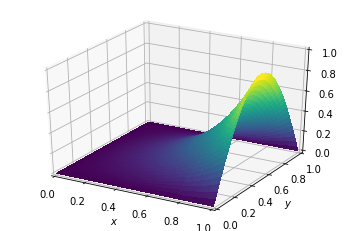

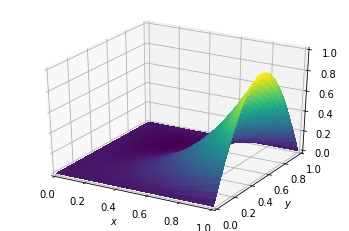

In [51]:
x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1, ny)
def analytic_solution(x):
    return (1 / (np.exp(np.pi) - np.exp(-np.pi))) * \
    		np.sin(np.pi * x[0]) * (np.exp(np.pi * x[1]) - np.exp(-np.pi * x[1]))
surface = np.zeros((ny, nx))

for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface[i][j] = analytic_solution([x, y])
        
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');


x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1, ny)
def A(x):
    return x[1] * np.sin(np.pi * x[0])


def psy_trial(x, net_out):
    return A(x) + x[0] * (1 - x[0]) * x[1] * (1 - x[1]) * net_out

surface1 = np.zeros((ny, nx))

for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface1[i][j] = psy_trial((x,y), model(np.array([x,y]).reshape(1,2))[0][0].numpy())
        
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface1, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [0]:
model(np.array([x,y]).reshape(1,2))

In [52]:
for i, x in enumerate(xx):
    for j, y in enumerate(yy):
        print(model(np.array([x,y]).reshape(1,2))[0][0].numpy())

-3.0002127
-3.1115022
-3.2192364
-3.3269708
-3.4347048
-3.5424392
-3.6501734
-3.7579076
-3.8656418
-3.9733763
-4.0811105
-4.1888447
-4.2965794
-4.404313
-4.512048
-4.619782
-4.727516
-4.8352504
-4.942985
-5.0507193
-5.1584535
-5.2661877
-5.373922
-5.481656
-5.5893908
-5.697125
-5.804859
-5.9125934
-6.020328
-6.1280622
-6.2357965
-6.3435307
-6.4512653
-6.558999
-6.6667333
-6.7744675
-6.882202
-6.989936
-7.0976706
-7.2054043
-7.313139
-7.420873
-7.5286074
-7.636342
-7.7440763
-7.8518105
-7.959544
-8.06728
-8.175014
-8.282747
-3.161487
-3.2831078
-3.3983374
-3.506782
-3.6145165
-3.7222505
-3.829985
-3.9377193
-4.0454535
-4.1531878
-4.260922
-4.368656
-4.476391
-4.584125
-4.6918592
-4.7995934
-4.907328
-5.0150623
-5.1227965
-5.2305307
-5.338265
-5.445999
-5.553734
-5.6614676
-5.769202
-5.8769364
-5.9846706
-6.0924053
-6.20014
-6.3078737
-6.415608
-6.523342
-6.6310763
-6.738811
-6.8465447
-6.954279
-7.062013
-7.169748
-7.277482
-7.3852167
-7.4929504
-7.600684
-7.708419
-7.8161535
-7.923888


KeyboardInterrupt: ignored